# Assignment 2 - DS4Biz Y63
## TextScraping_Classification
***

### Team Detail
**Team Name**: jonas   
***
### *Student 1*
**Student ID**: 61070296   
**Student Full Name**: ณัฐวุฒิ  อกนิษฐ์ศุภร
***
### *Student 2*
**Student ID**: 61070319   
**Student Full Name**: โรจนัสถ์ รอดรุ่งเรือง
***

# Import Library

In [199]:
import requests
import bs4
from pprint import pprint
import pandas as pd
import numpy as np
import warnings
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import recall_score, precision_score,f1_score
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')

# Scraping Websites

ทำการ Scraping หน้าเว็บเพื่อเอาข้อมูลของแต่ละข่าวมาทำการทำนายประเภทของแต่ละข่าว

### Function scraping web

In [2]:
def month(link,target):#เป็นฟังชั้นที่ใช้ Scraping ของหน้าแต่ละเดือนเพื่อเอาข้อมูล Target
    response = requests.get(link)
    html_page = bs4.BeautifulSoup(response.content, 'html.parser')
    selector = "body > div > div.main > table > tbody > tr > td.category"#เลือกตารางในส่วนของเฉพาะ Category
    tag = html_page.select(selector)
    for i in tag:
        target.append(i.text.strip())# นำข้อมูลของแต่ละ Category มาเพิ่มเข้าตาราง Target
        
def news(link,links,des):#เป็นฟังชั้นที่ใช้ Scraping ของหน้าแต่ละเดือนเพื่อเอาข้อมูล Links ของแต่ละข่าวเพื่อนำไปเข้าสู่เนื้อหาของแต่ละข่าว
    response = requests.get(link)
    html_page = bs4.BeautifulSoup(response.content, 'html.parser')
    selector = "body > div > div.main > table > tbody > tr > td.title > a"#เลือกตารางในส่วนของเฉพาะ a
    tag = html_page.select(selector)
    for i in tag:
#         print(i['href'])
        links.append(i['href'])# นำข้อมูลของแต่ละ Category มาเพิ่มเข้าตาราง links
        descrip('http://www.it.kmitl.ac.th/~teerapong/news_archive/' + i['href'], des)#นำข้อมูลของ Links มาเชื่อมต่อเข้าสู่เนื้อหาของแต่ละข่าว
        
def descrip(link,des):#เป็นฟังชั้นที่ใช้ Scraping ของหน้าแต่ละเดือนเพื่อเอาข้อมูล Links ของแต่ละข่าวเพื่อนำไปเข้าสู่เนื้อหาของแต่ละข่าว
    text = ""
    response = requests.get(link)
    html_page = bs4.BeautifulSoup(response.content, 'html.parser')
    selector = "body > div > div.main > h2"#เลือกหัวข้อข่าวของ Tag h2
    tag = html_page.select_one(selector)
#     text = text + tag.text + " " เป็นการ Scraping หัวข้อข่าวมาเก็บเข้า String Text
    
    response = requests.get(link)
    html_page = bs4.BeautifulSoup(response.content, 'html.parser')
    selector = "body > div > div.main > p" #เลือกเนื้อหาข่าวของ Tag p
    tag2 = html_page.select(selector)
    for i in tag2:# Loop เพื่อดูข้อมูลของแต่ละเนื้อหาข่าวเพื่อนำมาเช็คเงื่อนไข
#         print(i.text)
        if i.text == tag.text:# ดักเพื่อดูว่าบางเนื้อหาข่าวมีชื่อหัวข้อข่าวมาซ้ำกับของ Tag h2 จึงไม่ทำการเพิ่ม
            continue
        elif i.text in ['Return to article search results','Comments are closed for this article.']:# ดักเพื่อไม่ให้นำประโยคนี่ไปใช้ในการทำนายประเภทข่าว
            continue
        else:
            text = text + i.text# เพิ่มเนื้อหาที่ได้เข้าสู่ String Text เพื่อนำไป Save ลง File
    des.append(text.strip())# นำ String ที่ต่อกันแล้วมาลบช่องว่างระหว่างหน้าหลังด้วย Strip() แล้วทำการเพิ่มเข้า List Des

In [98]:
response = requests.get('http://www.it.kmitl.ac.th/~teerapong/news_archive/index.html')
html_page = bs4.BeautifulSoup(response.content, 'html.parser')
selector = "body > div.container > div.main > ul > li > a"# ดูข้อมูลของหน้า Index เพื่อเข้าแต่ละ Links ของแต่ละเดือน
tag = html_page.select(selector)
target = [] # List ของ Category ของแต่ละข่าว
des = [] # List คำอธิบายของแต่ละข่าว
links = [] # List ชื่อ Links ของแต่ละข่าว
for i in tag:
    month('http://www.it.kmitl.ac.th/~teerapong/news_archive/' + i['href'],target)
    news('http://www.it.kmitl.ac.th/~teerapong/news_archive/' + i['href'], links , des)

## Save data in text file

In [16]:
newwwww = [] #List Category ที่ผ่านการกรองแล้ว
text_target = "" 
for i in target:
    if i == 'N/A': #ถ้า Category เป็น N/A จะไม่ทำการเพิ่มเข้า List newwwww
        continue
    else:
        newwwww.append(i)
        text_target = text_target + i.strip() + "\n" #ทำการตัดช่องว่างและเพิ่มขึ้นบรรทัดใหม่ให้แต่ละ Category
f = open("target.txt", "w",encoding ='utf-8')
f.write(text_target.strip()) # Save เข้าไฟล์ที่ชื่อ target.txt
f.close()

In [7]:
text_links = ""
for i in links:
    text_links = text_links + i.strip() + "\n" #ทำการตัดช่องว่างและเพิ่มขึ้นบรรทัดใหม่ให้แต่ละ Links
f = open("links.txt", "w",encoding ='utf-8')
f.write(text_links.strip()) # Save เข้าไฟล์ที่ชื่อ links.txt
f.close()

In [100]:
text_des = ""
for i in des:
    text_des = text_des + i.strip() + "\n" #ทำการตัดช่องว่างและเพิ่มขึ้นบรรทัดใหม่ให้แต่ละเนื้อหาข่าว
f = open("contentwithoutheader.txt", "w",encoding ='utf-8')
f.write(text_des.strip())  # Save เข้าไฟล์ที่ชื่อ desnohead.txt
f.close()

# Load data without header File

โหลดข้อมูลที่ทำการเก็บแบบไม่มีหัวข้อของแต่ละข่าว

In [306]:
 f = open('target.txt','r',encoding='utf-8') # Load ไฟล์ Target
target = [] # List แต่ละ Category
for i in f:
    target.append(i.strip())
f.close()
y = target # เซ็ตค่า y ให้เป็นList ของแต่ละ Category

In [307]:
 f = open('contentwithoutheader.txt','r',encoding='utf-8') # Load ไฟล์ des ที่ไม่มีหัวข้อข่าว
data = [] # List ของเนื้อหาของแต่ละข่าว
for i in f:
    data.append(i.strip())
f.close()

# Create DataFrame

ทำการสร้าง DataFrame เพื่อจับคู่เนื้อหาของข่าวกับ Category ของข่าวนั้นๆ

In [238]:
df =  pd.DataFrame({'Des' : data, 'Target' : target}) #สร้าง Dataframe โดยมี Column Des กับ Target ของแต่ละข่าว
df

,Des,Target
0,The sporting industry has come a long way sinc...,technology
1,Shares in Europe's leading reinsurers and trav...,business
2,BT is offering customers free internet telepho...,technology
3,Shares in UK banking group Barclays have risen...,business
4,England centre Olly Barkley has been passed fi...,sport
...,...,...
1403,Toulouse's former Irish international Trevor B...,sport
1404,"The trial of Bernie Ebbers, former chief execu...",business
1405,Russian oil firm Yukos lied to a US court in a...,business
1406,Russian oil company Yukos has dropped the thre...,business


In [239]:
len(data)

1408

In [240]:
data[1]

'Shares in Europe\'s leading reinsurers and travel firms have fallen as the scale of the damage wrought by tsunamis across south Asia has become apparent.More than 23,000 people have been killed following a massive underwater earthquake and many of the worst hit areas are popular tourist destinations. Reisurance firms such as Swiss Re and Munich Re lost value as investors worried about rebuilding costs. But the disaster has little impact on stock markets in the US and Asia.Currencies including the Thai baht and Indonesian rupiah weakened as analysts warned that economic growth may slow. "It came at the worst possible time," said Hans Goetti, a Singapore-based fund manager. "The impact on the tourist industry is pretty devastating, especially in Thailand." Travel-related shares dropped in Europe, with companies such as Germany\'s TUI and Lufthansa and France\'s Club Mediterranne sliding. Insurers and reinsurance firms were also under pressure in Europe.Shares in Munich Re and Swiss Re -

# Text Preprocessing

## Function Tokenizer

In [241]:
from sklearn.feature_extraction import text
stopwords = text.ENGLISH_STOP_WORDS#เป็นการdownload คำstopword
def stopword(texts):#เป็น function ในการลบเอาstopword ออกจากtokenในตัวข้อมูลของเรา
    standard_tokenizer = CountVectorizer().build_tokenizer()#เป็นการสร้างfunctionในการสร้างtoken
    tokens = standard_tokenizer(texts)#เป็นการนำข้อมูล quotesมาทำการตัดคำ
    text_tokens = []#list ที่ใช้เก็บคำที่ไม่มีsotpwordอยู่ในนั้นเพื่อเตรียมเอาเข้าbag of word
    for token in tokens:#loop เพื่อดึงคำจากที่เราทำtokenไว้เพ่ือนำไปเช็คว่าคำไหนเป็นstop word
        if not token in stopwords:#เงื่อนไขที่เอาไว้check ว่าคำไหนไม่ใช่stop word
            text_tokens.append(token)#เก็บคำที่ไม่ใช้stop wordไว้ในlist
    return text_tokens
def lemma_tokenizer(tokens):
    lemmatizer = nltk.stem.WordNetLemmatizer() #เป็นการสร้างfunction ในการแปลงคำ
    lemma_tokens = [] #listที่เก็บคำหลังจากท่ีแปลงผ่านfunctionแล้ว
    for token in tokens: #loopเพื่อที่จะเอาคำไปแปลง
        lemma_tokens.append( lemmatizer.lemmatize(token)) #เป็นการแปลงคำศัพท์และนำเก็บลงlist lemma_tokens
    return lemma_tokens

## Filter Stopword

ทำการตัดคำ Stopword เช่น Is am are เนื่องจากเป็นคำที่ไม่สามารถนำมาใช้ในการทำนายได้จึงทำการ Loop เพื่อลบศัพท์เหล่านั้น

In [258]:
count = 0
for i in data:
    token = stopword(i)  # นำเนื้อหาข่าวเข้าฟังชั้น stopword เพื่อทำการตัดคำ Stopword
    lemma = lemma_tokenizer(token) # นำเข้าฟังชั้น Lemme_tokenizer เพื่อทำการแปลงคำ
    text = ''
    for word in lemma: # นำคำศัพท์ที่ผ่านการแปลงคำมาแล้วมาแทนค่า Data เก่าที่ไม่ได้ทำการตัดคำ Stopword 
        text += word + ' '
    data[count]= text
    count += 1

In [259]:
data

['The sporting industry come long way 60 It carved niche root deep fathom sport industry showing sign decline time soon later The reason seemingly subtle difference industry customer sporting industry fan Vivek Ranadivé leader ownership group NBA Sacramento Kings explained beautifully Fans paint face purple fan evangelize Every CEO business dying position dying fan While fan passion certainly industry going league sporting franchise decided rest laurel The year seen steady introduction technology world sport amplifying fan appreciation game enhancing athlete public profile informing training method influencing contest waged Also digital technology particular helped create alternative source revenue game corporate sponsorship They achieved capitalizing ardor customer base sorry fan base ',
 'Shares Europe leading reinsurers travel firm fallen scale damage wrought tsunami south Asia apparent More 23 000 people killed following massive underwater earthquake worst hit area popular tourist 

In [260]:
vectorizer = TfidfVectorizer(min_df = 10) # เป็นการเลือกความถี่ของแต่ละคำศัพท์ว่ามีความถี่มากกว่า 10 หรือไม่ถ้าน้อยกว่า 10 จะไม่นำมาใช้ในการทำ Model
X = vectorizer.fit_transform(data)
print(X.shape)

(1408, 3801)


# Data Without Header Model

ในการทำ Model ของข้อมูลนี่เป็นการทำนายแบบ Multi-class จึงเลือกใช้ Model Logistic Regression ,Naive Bayes และ Support Vector Machines (SVM) โดยในส่วนของ Naive Bayes นั้นมีอีก 2 Model ที่สามารถทำนายแบบ Multi-class ได้คือ BernoulliNB และ MultinomialNB โดยการทำ Model ทั้งหมดจะทำแบบ Nested Cross Validation เพื่อทำการ Tune Parameter ของแต่ละ Model เพื่อให้ได้ Model ที่เหมาะสมที่สุด

## Logistic Regression

In [280]:
Bar_y_without_header = [] # List ที่ไว่เก็บค่า Accuracy ของแต่ละ Model

In [281]:
from sklearn.linear_model import LogisticRegression
cv_inner = KFold(n_splits=3, random_state=1) #เลือกรอบCross Validate รอบใน
model = LogisticRegression()
space = dict() # ไว้เลือก Parameter เพื่อทำการ Tune
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
space['C'] = [0.1, 1, 10]
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True) # ทำการสร้าง Model ที่ใช้ในการ Tune Parameter
cv_outer = KFold(n_splits=10, random_state=1) #เลือกรอบ Cross Validate รอบนอก
scores = cross_val_score(search, X, y, scoring='accuracy', cv=cv_outer, n_jobs=-1) # ทำ Cross Validate โดยใช้ Model ของ GridSearchCV เพื่อค่า Parameter ที่ดีที่สุด
print('Accuracy: %.2f %s' % (mean(scores)*100, '%'))
Bar_y_without_header.append(float("%.2f" %(mean(scores)*100))) # นำค่า Accuracy เข้าตาราง Bar_y_without_header

Accuracy: 98.08 %


In [282]:
search.fit(X,y)
search.best_params_

{'C': 10, 'solver': 'newton-cg'}

โดยค่า Parameter ที่ดีที่สุดคือ C = 10 และ Solver เป็น newton-cg

## Naive Bayes BernoulliNB

In [283]:
from sklearn.naive_bayes import BernoulliNB
cv_inner = KFold(n_splits=3, shuffle=True, random_state=1) 
model = BernoulliNB()
space = dict()
space['alpha'] = [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
space['fit_prior'] = ['TRUE','FALSE']
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(search, X, y, scoring='accuracy', cv=cv_outer, n_jobs=-1)
print('Accuracy: %.2f %s' % (mean(scores)*100, '%'))
Bar_y_without_header.append(float("%.2f" %(mean(scores)*100)))

Accuracy: 97.80 %


In [284]:
search.fit(X,y)
search.best_params_

{'alpha': 0.01, 'fit_prior': 'TRUE'}

โดยค่า Parameter ที่ดีที่สุดคือ alpha = 0.01 และ fit_prior เป็น TRUE

## Naive Bayes MultinomialNB

In [285]:
from sklearn.naive_bayes import MultinomialNB
cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
model = MultinomialNB()
space = dict()
space['alpha'] = [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
space['fit_prior'] = ['TRUE','FALSE']
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(search, X, y, scoring='accuracy', cv=cv_outer, n_jobs=-1)
print('Accuracy: %.2f %s' % (mean(scores)*100, '%'))
Bar_y_without_header.append(float("%.2f" %(mean(scores)*100)))

Accuracy: 97.94 %


In [286]:
search.fit(X,y)
search.best_params_

{'alpha': 0.5, 'fit_prior': 'TRUE'}

โดยค่า Parameter ที่ดีที่สุดคือ alpha = 0.5 และ fit_prior เป็น TRUE

## Support Vector Machines (SVM)

In [287]:
from sklearn import svm
cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
model =svm.SVC()
space = dict()
space['gamma'] = [1, 0.1, 0.01]
space['C'] = [0.1, 1, 10]
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(search, X, y, scoring='accuracy', cv=cv_outer, n_jobs=-1) 
print('Accuracy: %.2f %s' % (mean(scores)*100, '%'))
Bar_y_without_header.append(float("%.2f" %(mean(scores)*100))) 

Accuracy: 98.44 %


In [288]:
search.fit(X,y)
search.best_params_

{'C': 10, 'gamma': 0.1}

โดยค่า Parameter ที่ดีที่สุดคือ C = 10 และ gamma เป็น 0.1

# ---------------------------------------------------------------------------------------------------------

# Load Data With Header

ทำการทำนาย Category ด้วยข้อมูลที่มีหัวข้อของแต่ละข่าว

In [310]:
f = open('contentwithheader.txt','r',encoding='utf-8')
data = []
for i in f:
    data.append(i.strip())
f.close()

# Create DataFrame

In [290]:
df =  pd.DataFrame({'Des' : data, 'Target' : target})
df

,Des,Target
0,21st-Century Sports: How Digital Technology Is...,technology
1,Asian quake hits European shares Shares in Eur...,business
2,BT offers free net phone calls BT is offering ...,technology
3,Barclays shares up on merger talk Shares in UK...,business
4,Barkley fit for match in Ireland England centr...,sport
...,...,...
1403,Woodward eyes Brennan for Lions Toulouse's for...,sport
1404,WorldCom trial starts in New York The trial of...,business
1405,Yukos accused of lying to court Russian oil fi...,business
1406,Yukos drops banks from court bid Russian oil c...,business


In [291]:
len(data)

1408

In [292]:
data[1]

'Asian quake hits European shares Shares in Europe\'s leading reinsurers and travel firms have fallen as the scale of the damage wrought by tsunamis across south Asia has become apparent.More than 23,000 people have been killed following a massive underwater earthquake and many of the worst hit areas are popular tourist destinations. Reisurance firms such as Swiss Re and Munich Re lost value as investors worried about rebuilding costs. But the disaster has little impact on stock markets in the US and Asia.Currencies including the Thai baht and Indonesian rupiah weakened as analysts warned that economic growth may slow. "It came at the worst possible time," said Hans Goetti, a Singapore-based fund manager. "The impact on the tourist industry is pretty devastating, especially in Thailand." Travel-related shares dropped in Europe, with companies such as Germany\'s TUI and Lufthansa and France\'s Club Mediterranne sliding. Insurers and reinsurance firms were also under pressure in Europe.S

# Text Preprocessing

## Filter Stopword

In [293]:
count = 0
for i in data:
    token = stopword(i)
    text = ''
    for word in token:
        text += word + ' '
    data[count]= text
    count += 1

In [294]:
vectorizer = TfidfVectorizer(min_df = 10)
X = vectorizer.fit_transform(data)
print(X.shape)

(1408, 4156)


# Data With Header Model

## Logistic Regression

In [295]:
Bar_y_with_header = []

In [296]:
from sklearn.linear_model import LogisticRegression
cv_inner = KFold(n_splits=3, random_state=1)
model = LogisticRegression()
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
space['C'] = [0.1, 1, 10]
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
cv_outer = KFold(n_splits=10, random_state=1)
scores = cross_val_score(search, X, y, scoring='accuracy', cv=cv_outer, n_jobs=-1)
print('Accuracy: %.2f %s' % (mean(scores)*100, '%'))
Bar_y_with_header.append(float("%.2f" %(mean(scores)*100)))

Accuracy: 98.29 %


In [297]:
search.fit(X,y)
search.best_params_

{'C': 10, 'solver': 'newton-cg'}

โดยค่า Parameter ที่ดีที่สุดคือ C = 10 และ solver เป็น newton-cg

## Naive Bayes BernoulliNB

In [298]:
from sklearn.naive_bayes import BernoulliNB
cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
model = BernoulliNB()
space = dict()
space['alpha'] = [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
space['fit_prior'] = ['TRUE','FALSE']
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(search, X, y, scoring='accuracy', cv=cv_outer, n_jobs=-1)
print('Accuracy: %.2f %s' % (mean(scores)*100, '%'))
Bar_y_with_header.append(float("%.2f" %(mean(scores)*100)))

Accuracy: 97.87 %


In [299]:
search.fit(X,y)
search.best_params_

{'alpha': 0.1, 'fit_prior': 'TRUE'}

โดยค่า Parameter ที่ดีที่สุดคือ alpha = 0.01 และ fit_prior เป็น TRUE

## Naive Bayes MultinomialNB

In [300]:
from sklearn.naive_bayes import MultinomialNB
cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
model = MultinomialNB()
space = dict()
space['alpha'] = [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
space['fit_prior'] = ['TRUE','FALSE']
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(search, X, y, scoring='accuracy', cv=cv_outer, n_jobs=-1)
print('Accuracy: %.2f %s' % (mean(scores)*100, '%'))
Bar_y_with_header.append(float("%.2f" %(mean(scores)*100)))

Accuracy: 97.73 %


In [301]:
search.fit(X,y)
search.best_params_

{'alpha': 0.1, 'fit_prior': 'TRUE'}

โดยค่า Parameter ที่ดีที่สุดคือ alpha = 0.01 และ fit_prior เป็น TRUE

## Support Vector Machines (SVM)

In [302]:
from sklearn import svm
cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
model =svm.SVC()
space = dict()
space['gamma'] = [1, 0.1, 0.01]
space['C'] = [0.1, 1, 10]
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(search, X, y, scoring='accuracy', cv=cv_outer, n_jobs=-1)
print('Accuracy: %.2f %s' % (mean(scores)*100, '%'))
Bar_y_with_header.append(float("%.2f" %(mean(scores)*100)))

Accuracy: 98.44 %


In [303]:
search.fit(X,y)
search.best_params_

{'C': 10, 'gamma': 0.1}

โดยค่า Parameter ที่ดีที่สุดคือ C = 10 และ gamma เป็น 0.1

# Summary

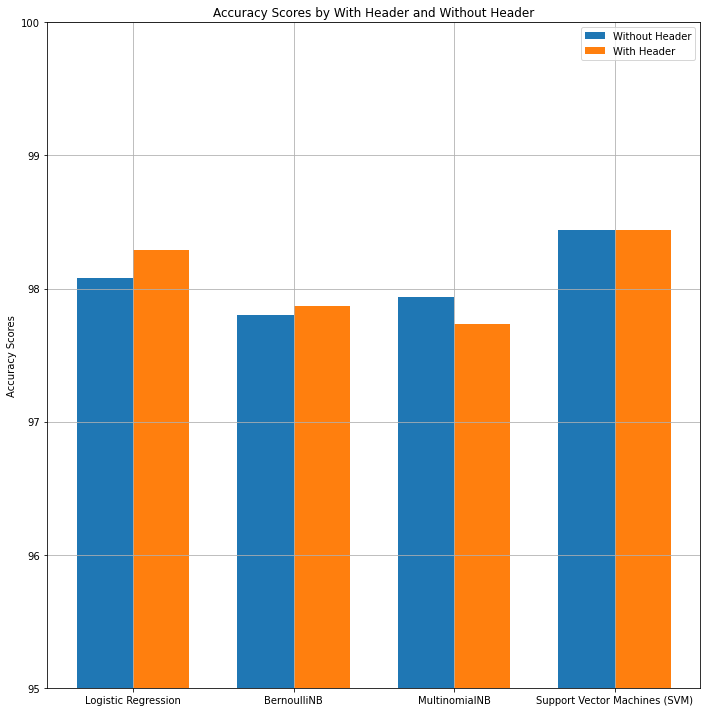

In [305]:
Bar_x = ['Logistic Regression','BernoulliNB','MultinomialNB','Support Vector Machines (SVM)']
x = np.arange(len(Bar_x))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 10))
rects1 = ax.bar(x - width/2, Bar_y_without_header, width, label='Without Header')
rects2 = ax.bar(x + width/2, Bar_y_with_header, width, label='With Header')
plt.grid()
plt.ylim(95,100)

ax.set_ylabel('Accuracy Scores')
ax.set_title('Accuracy Scores by With Header and Without Header')
ax.set_xticks(x)
ax.set_xticklabels(Bar_x)
ax.legend()

fig.tight_layout()

จากกราฟด้านบนจะเห็นได้ว่า Model ที่ผ่านการทำ Nested Cross Validation เพื่อทำการ Tune Parameter มาแล้ว โดยจะเห็นว่า Model แบบSupport Vector Machines (SVM) นั้นมีค่าความแม่นยำที่สุดทั้งข้อมูลแบบมีหัวข้อข่าวและข้อมูลที่ไม่มีหัวข้อข่าวแต่เมื่อดู Model อื่นๆจะเห็นว่า Logistic Regression และ Naive Bayes แบบ BernoulliNB นั้นในส่วนของข้อมูลแบบมีหัวข้อข่าวนั้นมีค่า Accuracy มากกว่าแบบไม่มีหัวข้อข่าว

สรุปได้ว่า Model ของ Support Vector Machines (SVM) ได้ค่า Accuracy มากที่สุด และข้อมูลที่ได้ค่า Accuracy มากที่สุดคือข้อมูลที่มีหัวข้อข่าวจึงสรุปได้ว่า Model ที่ดีที่สุดคือ Model Support Vector Machines (SVM) และใช้ข้อมูลแบบมีหัวข้อข่าวเพื่อให้ได้ค่า Accuracy ที่มากที่สุด